# Niche Hashtag & Creator Clusters
Analyzing Identity Clusters behind #sahm TikTok Creators: A Study on the Creator’s Use of Hashtags and Their Suggested Niche Identities

Yolanda Zhang (DS340H)

Necessary imports for data cleaning

In [ ]:
#imports
import zipfile
import json
from datetime import datetime
import pandas as pd
from itertools import combinations
from collections import Counter
from collections import defaultdict
import networkx as nx
import community as community_louvain
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import pipeline
from sklearn.manifold import TSNE
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step 1: remove personal information to protect user's privacy. 

Step 2: filter out hashtags that are overly generic or rare

In [5]:
#convert hashtags into lowercase
dataframe['hashtag_names'] = dataframe['hashtag_names'].apply(
    lambda tags: [tag.lower() for tag in tags] if isinstance(tags, list) else []
)

#make each hashtag an individual row in a new dataframe
hashtags_exploded = dataframe.explode('hashtag_names')

#count the frequency of each hashtag
hashtag_counts = (
    hashtags_exploded['hashtag_names']
    .value_counts()
    .reset_index()
)
hashtag_counts.columns = ['hashtag', 'count']

#ensure counts are numeric
hashtag_counts['count'] = pd.to_numeric(hashtag_counts['count'], errors='coerce')

#filter out hashtags that are extremely rare
filtered_counts = hashtag_counts[hashtag_counts['count'] >= 100]

#filter out hashtags that are generic
generic_tags = [
    'fyp', 'foryou', 'foryoupage', 'viral', 'trending',
    'explore', 'follow', 'tiktok', 'reels', 'tiktokviral',
    'foryourpage', 'fypシ゚viral', 'trend', 'funny', 'tiktoktrend',
    'explorepage', 'newtrend', 'featureme'
]
filtered_counts = filtered_counts[~filtered_counts['hashtag'].isin(generic_tags)]

#convert filtered hashtags to a set for fast lookup
valid_hashtags = set(filtered_counts['hashtag'])

#keep only hashtags that are in the valid set
dataframe['hashtag_names_filtered'] = dataframe['hashtag_names'].apply(
    lambda tags: [t for t in tags if t in valid_hashtags]
)


Verify the result:

In [6]:
dataframe[['hashtag_names', 'hashtag_names_filtered']].head()

,hashtag_names,hashtag_names_filtered
0,"[mama, mother, messyhair, dontcare, kitchen, h...","[mama, mother, messyhair, dontcare, kitchen, h..."
1,"[bored, merica, sahm, whenthekidsareaway, lovi...","[bored, merica, sahm]"
2,"[momlife, parenthood, sahm]","[momlife, parenthood, sahm]"
3,"[sahm, momofboth]","[sahm, momofboth]"
4,"[lovemykids, sahm, husbandsatwork]","[lovemykids, sahm]"


Step 4: create co-occurrence matrix

In [7]:
filtered_df = dataframe[dataframe['hashtag_names_filtered'].map(len) > 1]

# count the co-occurrences
pair_counter = Counter()

for tags in filtered_df['hashtag_names_filtered']:
    # remove duplicates and sort for consistency
    tags = sorted(set(tags))
    pair_counter.update(combinations(tags, 2))

#create a table
co_occurrence_df = pd.DataFrame(
    [(a, b, count) for (a, b), count in pair_counter.items()],
    columns=['Hashtag_A', 'Hashtag_B', 'count']
)

Verify the result:

In [231]:
co_occurrence_df.head()

,Hashtag_A,Hashtag_B,count
0,dontcare,housewife,2
1,dontcare,kitchen,2
2,dontcare,mama,8
3,dontcare,messyhair,8
4,dontcare,mother,3


In [233]:
print(len(co_occurrence_df["Hashtag_B"]))

11732520


Step 5: build clusters using Louvian Method to create network community

In [9]:
#create nodes and edges
G = nx.from_pandas_edgelist(
    co_occurrence_df,
    source='Hashtag_A',
    target='Hashtag_B',
    edge_attr='count',
    create_using=nx.Graph()
)

#keep only edges that appear more than 50 times together
edges_to_keep = [(u, v, d) for u, v, d in G.edges(data=True) if d['count'] >= 50]
G_filtered = nx.Graph()
G_filtered.add_edges_from(edges_to_keep)

partition = community_louvain.best_partition(G_filtered, weight='count')
clusters_df = pd.DataFrame(list(partition.items()), columns=['hashtag', 'community'])

#we then group the hashtag by the detected community
clusters_summary = (
    clusters_df
    .groupby('community')['hashtag']
    .apply(list)
    .reset_index()
)

Verify the result:

In [234]:
clusters_summary

,community,hashtag
0,0,"[dontcare, sahm, momsoftiktok, momlife, housew..."
1,1,"[amasdecasa, goldplatedjewelry, chicasqueusana..."
2,2,"[strollerstrides, workoutwithbaby, prenatalfit..."
3,3,"[workfromhome, stitch, lol, justforfun, 2022, ..."
4,4,"[comedy, stayathomemom, blessed, greenscreen, ..."
5,5,"[thesimpsons, koa, mylittlefamily, simpsons, m..."
6,6,"[happynewyear, crochet, lifeofasahm, keto, kni..."
7,7,"[texas, pregnant, pregnancy, love, ootd, viral..."
8,8,"[loveyou, countrygirl, 90skids, 90s, countrymu..."
9,9,"[fam, lovinglife, boomer, genx, spreadlovenoth..."


Step 6: collect niche hashtag candidates from each cluster

In [11]:
clustered_hashtags = clusters_df.merge(hashtag_counts, on='hashtag', how='left')

#rank hashtag by its frequency
top_hashtags_per_cluster = (
    clustered_hashtags
    .sort_values(['community', 'count'], ascending=[True, False])
    .groupby('community')
    .head(10)   #get the top 10 hashtag
)

#give each potential niche a row
niche_candidates = (
    top_hashtags_per_cluster
    .groupby('community')['hashtag']
    .apply(list)
    .reset_index()
    .rename(columns={'hashtag': 'niche_candidate_hashtags'})
)

#saving the niche candidates
niche_candidates.to_csv('niche_candidates.csv', index=False)

In [243]:
for item in niche_candidates["niche_candidate_hashtags"].head(1):
    print(item)

['sahm', 'momsoftiktok', 'momlife', 'momtok', 'sahmlife', 'mom', 'toddlermom', 'fypシ', 'sahmsoftiktok', 'boymom']


Verify the result:

In [12]:
niche_candidates.head()

,community,niche_candidate_hashtags
0,0,"[sahm, momsoftiktok, momlife, momtok, sahmlife..."
1,1,"[amasdecasa, girlsthatwearjewelry, stainlessst..."
2,2,"[prenatalfitness, strengthinmotherhood, stroll..."
3,3,"[workfromhome, digitalmarketing, passiveincome..."
4,4,"[stayathomemom, singlemom, motivation, duet, e..."


Step 7: create niche score for each niche hashtag candidate 

In [13]:
#compute total hashtag frequency P(h)
total_hashtag_count = hashtag_counts['count'].sum()
hashtag_counts['p_h'] = hashtag_counts['count'] / total_hashtag_count

#compute within cluster frequency P(h|c)
cluster_totals = (
    clustered_hashtags.groupby('community')['count'].sum()
    .rename('cluster_total')
    .reset_index()
)

if 'cluster_total' in clustered_hashtags.columns:
    clustered_hashtags = clustered_hashtags.drop(columns=['cluster_total'])
clustered_hashtags = clustered_hashtags.merge(cluster_totals, on='community', how='left')
clustered_hashtags['p_hc'] = clustered_hashtags['count'] / clustered_hashtags['cluster_total']


#merge gloabl frequencies (so each hashtag knows its p_h)
if 'p_h' in clustered_hashtags.columns:
    clustered_hashtags = clustered_hashtags.drop(columns=['p_h'])
clustered_hashtags = clustered_hashtags.merge(
    hashtag_counts[['hashtag', 'p_h']], on='hashtag', how='left'
)

#compute the niche score
clustered_hashtags['niche_score'] = clustered_hashtags['p_hc'] / clustered_hashtags['p_h']

#log-transform the score for interpretability
clustered_hashtags['log_niche_score'] = np.log(clustered_hashtags['niche_score'])

#identify the top niche hashtags per community
top_niche_per_cluster = (
    clustered_hashtags
    .sort_values(['community', 'niche_score'], ascending=[True, False])
    .groupby('community')
    .head(10)
)

#save the result
top_niche_per_cluster.to_csv('top_niche_hashtags.csv', index=False)


Verify the result:

In [14]:
top_hashtags_per_cluster.head()

,hashtag,community,count
1,sahm,0,2664881
2,momsoftiktok,0,847666
3,momlife,0,631837
96,momtok,0,448208
17,sahmlife,0,403346


Step 8: select the niche hashtags from each cluster 

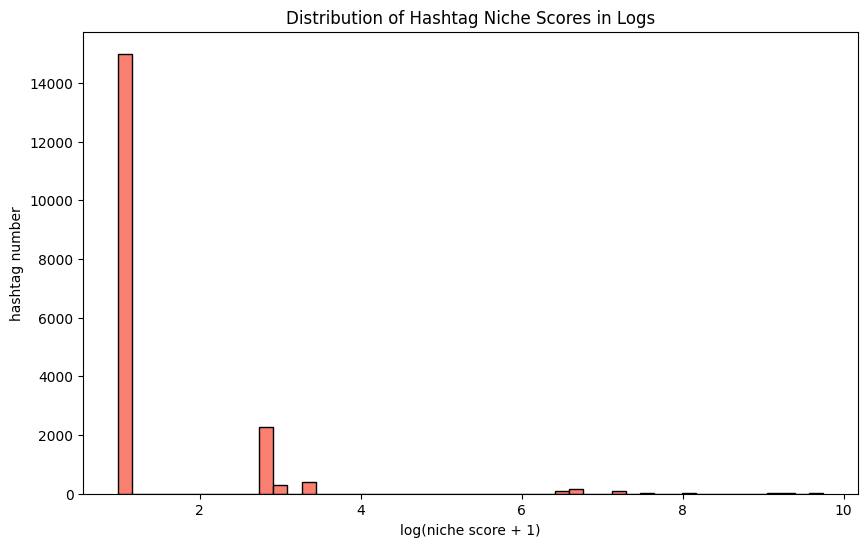

In [15]:
#create a histogram to check the distribution of hashtag niche scores
plt.figure(figsize=(10,6))
plt.hist(np.log1p(clustered_hashtags['niche_score']), bins=50, color='salmon', edgecolor='black')
plt.xlabel('log(niche score + 1)')
plt.ylabel('hashtag number')
plt.title('Distribution of Hashtag Niche Scores in Logs')
plt.show()

In [279]:
dataframe.head()

,like_count,region_code,share_count,comment_count,create_time,hashtag_names,view_count,video_description,voice_to_text,hashtag_names_filtered,has_niche,post_id,creator_id,niche_tags,niche_count
0,5,SG,0,0.0,2018-07-06 18:13:48,"[mama, mother, messyhair, dontcare, kitchen, h...",138,#messyhair#dontcare#justtiktok @Seraphina Gene...,NaN,"[mama, mother, messyhair, dontcare, kitchen, h...",False,0,0,[],0
1,570,US,0,2.0,2018-08-24 16:19:57,"[bored, merica, sahm, whenthekidsareaway, lovi...",11022,#bored #snapyourlife #thesebootsthough #merica...,NaN,"[bored, merica, sahm]",False,1,1,[],0
2,2101,US,16,4.0,2018-10-12 18:21:02,"[momlife, parenthood, sahm]",35412,I know it says kicked but I’d rather not get k...,NaN,"[momlife, parenthood, sahm]",False,2,2,[],0
3,2,US,0,0.0,2018-10-29 16:14:37,"[sahm, momofboth]",22,#SAHM #MomofBoth,NaN,"[sahm, momofboth]",False,3,3,[],0
4,1,US,0,0.0,2018-10-29 16:53:01,"[lovemykids, sahm, husbandsatwork]",29,"love being a mom who can work from home, and h...",NaN,"[lovemykids, sahm]",False,4,4,[],0


Given the distributino of hashtag niche scores, I've decided to set the threshold to be log(niche score + 1) >= 3

In [ ]:
threshold = np.exp(3) - 1
print(threshold)

#the threshold for hashtag's niche score is 19.085536923187668

19.085536923187668


In [137]:
#filter out niche hashtags that have a score that's above the threshold
niche_hashtags = clustered_hashtags[clustered_hashtags['niche_score'] > threshold ]

Verify the result: 

In [138]:
niche_hashtags.head()

,hashtag,community,count,cluster_total,p_hc,p_h,niche_score,log_niche_score
8,texas,7,10550,1244950,0.008474,0.000334,25.344681,3.232569
121,pregnant,7,48813,1244950,0.039209,0.001547,25.344681,3.232569
162,pregnancy,7,35052,1244950,0.028155,0.001111,25.344681,3.232569
174,love,7,47766,1244950,0.038368,0.001514,25.344681,3.232569
214,ootd,7,47398,1244950,0.038072,0.001502,25.344681,3.232569


Filter out fake niche hashtags

In [280]:
niche_hashtags['count'].describe()

count      864.000000
mean      1680.106481
std       3892.510772
min        100.000000
25%        214.000000
50%        380.000000
75%       2198.500000
max      48813.000000
Name: count, dtype: float64

In [282]:
niche_hashtags = niche_hashtags[niche_hashtags['count'] < 500]

In [ ]:
#number of niche hashtags = 480
print(len(niche_hashtags['hashtag']))

480


Step 9: create niche hashtag cluster groups using zero-shot learning

In [140]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

candidate_labels = ["Advice / Tips",
    "Relatable / Personal Story",
    "Humor / Entertainment",
    "Product / Promotion",
    "Motivation / Inspiration",
    "Lifestyle / Routine"]
results = classifier(niche_hashtags['hashtag'].tolist(), candidate_labels)
niche_hashtags['predicted_type'] = [r['labels'][0] for r in results]


Device set to use cpu
/var/folders/_p/1qc25tk13ql7x_lr03lr3wgc0000gn/T/ipykernel_4632/3806563192.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  niche_hashtags['predicted_type'] = [r['labels'][0] for r in results]


Verify the result: 

In [284]:
niche_hashtags.head(20)

,hashtag,community,count,cluster_total,p_hc,p_h,niche_score,log_niche_score,predicted_type
2555,dnd,12,273,46409,0.005882,0.000009,679.886681,6.521926,Relatable / Personal Story
3059,early2000s,8,358,40068,0.008935,0.000011,787.482804,6.668842,Relatable / Personal Story
3079,boomer,9,124,24772,0.005006,0.000004,1273.730865,7.149706,Relatable / Personal Story
3407,ketocoffee,6,145,36744,0.003946,0.000005,858.721451,6.755445,Relatable / Personal Story
3652,ketofood,6,129,36744,0.003511,0.000004,858.721451,6.755445,Relatable / Personal Story
3797,ketolife,6,245,36744,0.006668,0.000008,858.721451,6.755445,Lifestyle / Routine
3946,spreadlovenothate,9,132,24772,0.005329,0.000004,1273.730865,7.149706,Lifestyle / Routine
4068,accurate,7,423,1244950,0.000340,0.000013,25.344681,3.232569,Relatable / Personal Story
4163,brokenheart,7,335,1244950,0.000269,0.000011,25.344681,3.232569,Relatable / Personal Story
4205,ketolifestyle,6,176,36744,0.004790,0.000006,858.721451,6.755445,Humor / Entertainment


Step 10: visualize the dominant type of each cluster

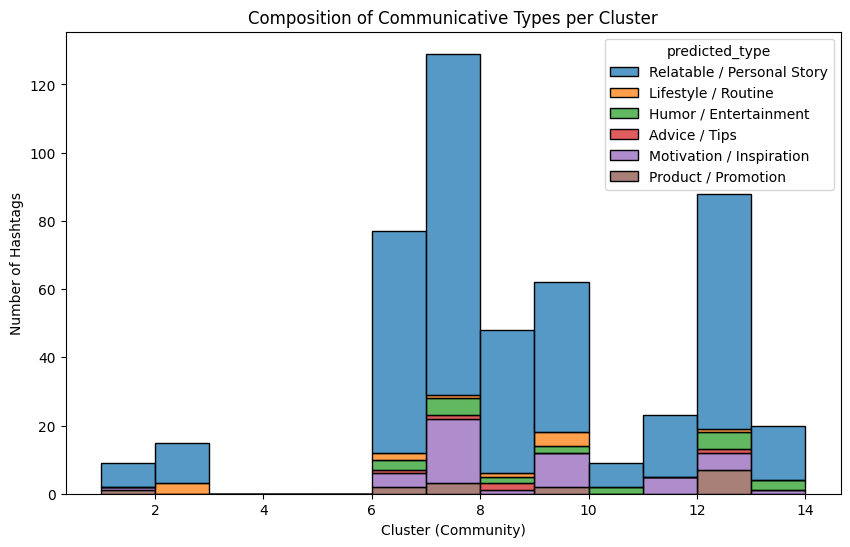

In [285]:
type_counts = (
    niche_hashtags
    .groupby(['community', 'predicted_type'])
    .size()
    .reset_index(name='count')
)

dominant_types = (
    type_counts
    .sort_values(['community', 'count'], ascending=[True, False])
    .drop_duplicates(subset=['community'])
)

plt.figure(figsize=(10,6))
sns.histplot(
    data=niche_hashtags,
    x='community',
    hue='predicted_type',
    multiple='stack'
)
plt.title("Composition of Communicative Types per Cluster")
plt.xlabel("Cluster (Community)")
plt.ylabel("Number of Hashtags")
plt.show()

Step 11: assign niche hahstags to posts  

Create unique identifier for each post

In [143]:
dataframe = dataframe.reset_index(drop=True)
dataframe["post_id"] = dataframe.index

Replace creator's username with a hashed value to protect individual privacy

In [ ]:
unique_users = dataframe["username"].unique()
user_map = {u: i for i, u in enumerate(unique_users)}
dataframe["creator_id"] = dataframe["username"].map(user_map)

In [ ]:
#drop the username column
dataframe.drop(['username'], axis=1, inplace=True)

Check the current dataframe to make sure nothing included is identifiable

In [52]:
dataframe.head(20)

,like_count,region_code,share_count,comment_count,create_time,hashtag_names,view_count,video_description,voice_to_text,hashtag_names_filtered,has_niche,post_id,creator_id
0,5,SG,0,0.0,2018-07-06 18:13:48,"[mama, mother, messyhair, dontcare, kitchen, h...",138,#messyhair#dontcare#justtiktok @Seraphina Gene...,NaN,"[mama, mother, messyhair, dontcare, kitchen, h...",False,0,0
1,570,US,0,2.0,2018-08-24 16:19:57,"[bored, merica, sahm, whenthekidsareaway, lovi...",11022,#bored #snapyourlife #thesebootsthough #merica...,NaN,"[bored, merica, sahm]",False,1,1
2,2101,US,16,4.0,2018-10-12 18:21:02,"[momlife, parenthood, sahm]",35412,I know it says kicked but I’d rather not get k...,NaN,"[momlife, parenthood, sahm]",False,2,2
3,2,US,0,0.0,2018-10-29 16:14:37,"[sahm, momofboth]",22,#SAHM #MomofBoth,NaN,"[sahm, momofboth]",False,3,3
4,1,US,0,0.0,2018-10-29 16:53:01,"[lovemykids, sahm, husbandsatwork]",29,"love being a mom who can work from home, and h...",NaN,"[lovemykids, sahm]",False,4,4
5,9,US,0,1.0,2018-10-29 20:06:25,[sahm],151,she was doing it tooo lol... #sahm,NaN,[sahm],False,5,5
6,6,US,0,0.0,2018-11-03 16:26:38,"[selfie, fitmom, motherhood, selflove, momlife...",81,@fangirlx8 #wahm #sahm #wingeyeliner #tattooed...,NaN,"[selfie, fitmom, motherhood, selflove, momlife...",False,6,6
7,11,US,0,0.0,2018-11-03 16:35:17,"[selfie, fitmom, motherhood, selflove, girlpow...",225,#wahm #sahm #wingeyeliner #tattooedmom #momlif...,NaN,"[selfie, fitmom, motherhood, selflove, girlpow...",False,7,6
8,9,US,0,0.0,2018-11-04 15:08:25,"[typicalsunday, sahm, noonehelps]",184,#SAHM #noonehelps #typicalsunday,NaN,[sahm],False,8,7
9,5,US,0,0.0,2018-11-07 22:51:26,"[mylife, sahm, wouldnthaveitanyotherway, alway...",117,#sahm #alwaysdriving #mylife #wouldnthaveitany...,NaN,"[mylife, sahm]",False,9,8


Assign niche groups to each post

In [286]:
niche_hashtags['hashtag'] = niche_hashtags['hashtag'].str.lower()
niche_set = set(niche_hashtags['hashtag'])

In [287]:
def contains_niche(hashtags):
    if not isinstance(hashtags, list):
        return False
    return any(tag.lower() in niche_set for tag in hashtags)

dataframe['has_niche'] = dataframe['hashtag_names_filtered'].apply(contains_niche)

#proportion of posts that contain ≥1 niche hashtag
proportion = dataframe['has_niche'].mean()

print(f"Proportion of posts containing niche hashtags: {proportion:.2%}")

Proportion of posts containing niche hashtags: 1.00%


Create a niche tags list for each post

In [288]:
def get_niche_tags(tag_list):
    if not isinstance(tag_list, list):
        return []

    result = []
    for t in tag_list:
        if isinstance(t, str):
            lower_t = t.lower()
            if lower_t in niche_set:
                result.append(lower_t)

    return result

dataframe['niche_tags'] = dataframe['hashtag_names_filtered'].apply(get_niche_tags)

Step 12: build post x niche matrix

In [289]:
post_niche_long = (
    dataframe[['niche_tags']]
    .reset_index()
    .rename(columns={'index': 'post_id'})
    .explode('niche_tags')
)

post_niche_long = post_niche_long.dropna(subset=['niche_tags'])

post_niche_matrix = (
    post_niche_long
    .pivot_table(index='post_id', columns='niche_tags', aggfunc='size', fill_value=0)
)

post_niche_matrix = (post_niche_matrix > 0).astype(int)

Result:

In [290]:
dataframe['niche_tags'].head(20)

0     []
1     []
2     []
3     []
4     []
5     []
6     []
7     []
8     []
9     []
10    []
11    []
12    []
13    []
14    []
15    []
16    []
17    []
18    []
19    []
Name: niche_tags, dtype: object

In [291]:
dataframe['niche_tags'].apply(len).value_counts()

niche_tags
0     2638210
1       19378
2        2198
3         955
15        608
9         391
4         333
21        261
24        253
73        200
12        191
16        176
6         164
33        156
5         151
14        121
18        108
35        104
10        102
17         98
22         97
38         83
8          66
7          64
60         48
11         43
52         32
37         30
41         27
13         27
54         27
59         24
34         22
71         21
20         18
57         11
26          9
53          9
56          9
27          8
70          8
55          7
32          6
23          5
46          4
58          4
42          4
19          3
47          2
28          2
40          1
29          1
61          1
Name: count, dtype: int64

In [292]:
post_niche_matrix.head(10)

niche_tags,00td,111,11minutesapart,2000sthrowbacks,222,30weeks,32weeks,33weeks,3rdnorth,3yearsold,...,💙👑wcfa👑💙,💙👑wcf👑💙,💙👑westcoastfinest👑💙,💙👑westcoastfinest👑💙affiliated,💙👑worldwidesfinest👑💜,💙👑wwf👑💙,🔥flameofarose🌹,🔥legit🔥empire🔥modz✅,🔥🌹imperial🦋hermosa⚜️,🤍💎💫sheikhsdiamonds💫💎🤍
post_id,,,,,,,,,,,,,,,,,,,,,
789,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
805,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1816,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2686,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Step 13: aggregate to the creator level

In [293]:
post_niche_matrix['creator_id'] = dataframe['creator_id']
creator_niche_matrix = (
    post_niche_matrix
    .groupby('creator_id')
    .sum()     # count of each niche used by creator
)

#convert counts to proportion of posts
creator_post_counts = dataframe.groupby('creator_id').size()

creator_niche_prop = creator_niche_matrix.div(creator_post_counts, axis=0)

Results:

In [294]:
creator_post_counts.head()

creator_id
0    1
1    1
2    4
3    2
4    1
dtype: int64

In [295]:
creator_niche_prop.head()

niche_tags,00td,111,11minutesapart,2000sthrowbacks,222,30weeks,32weeks,33weeks,3rdnorth,3yearsold,...,💙👑wcfa👑💙,💙👑wcf👑💙,💙👑westcoastfinest👑💙,💙👑westcoastfinest👑💙affiliated,💙👑worldwidesfinest👑💜,💙👑wwf👑💙,🔥flameofarose🌹,🔥legit🔥empire🔥modz✅,🔥🌹imperial🦋hermosa⚜️,🤍💎💫sheikhsdiamonds💫💎🤍
creator_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Step 14: compute entropy score

In [296]:
entropy = - (creator_niche_prop * np.log(creator_niche_prop + 1e-12)).sum(axis=1)

In [297]:
entropy.name = "entropy"
entropy.head()

creator_id
0   -0.0
1   -0.0
2   -0.0
3   -0.0
4   -0.0
Name: entropy, dtype: float64

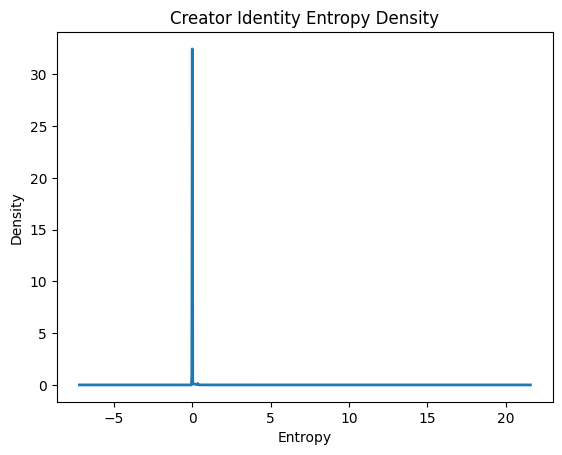

In [298]:
entropy.plot(kind="density", linewidth=2)
plt.xlabel("Entropy")
plt.title("Creator Identity Entropy Density")
plt.show()


Step 15: identity consistency v.s. identity fluidity

In [299]:
norm_entropy = entropy / np.log(len(creator_niche_prop.columns))
norm_entropy.name = "normalized_entropy"

In [300]:
dataframe['niche_count'] = dataframe['niche_tags'].apply(lambda x: len(x))
dataframe['niche_count'].value_counts()


niche_count
0     2638210
1       19378
2        2198
3         955
15        608
9         391
4         333
21        261
24        253
73        200
12        191
16        176
6         164
33        156
5         151
14        121
18        108
35        104
10        102
17         98
22         97
38         83
8          66
7          64
60         48
11         43
52         32
37         30
41         27
13         27
54         27
59         24
34         22
71         21
20         18
57         11
26          9
53          9
56          9
27          8
70          8
55          7
32          6
23          5
46          4
58          4
42          4
19          3
47          2
28          2
40          1
29          1
61          1
Name: count, dtype: int64

In [301]:
identity_style = pd.Series(index=norm_entropy.index, dtype="object")

identity_style[norm_entropy < 0.25] = "consistent"
identity_style[(norm_entropy >= 0.25) & (norm_entropy <= 0.55)] = "mixed"
identity_style[norm_entropy > 0.55] = "fluid"

creator_identity_df = pd.concat(
    [
        creator_niche_matrix.add_prefix("count_"),     # count of niche hashtags
        creator_niche_prop.add_prefix("prop_"),        # proportion per niche
        norm_entropy.rename("entropy_norm"),           # normalized entropy
        identity_style.rename("identity_style")        # categorical label
    ],
    axis=1
)

Calculate the proportion for each style, most creators are consistent

In [302]:
creator_identity_df['identity_style'].value_counts(normalize=True)

identity_style
consistent    0.999673
mixed         0.000233
fluid         0.000094
Name: proportion, dtype: float64

In [303]:
creator_identity_df.head(20)

,count_00td,count_111,count_11minutesapart,count_2000sthrowbacks,count_222,count_30weeks,count_32weeks,count_33weeks,count_3rdnorth,count_3yearsold,...,prop_💙👑westcoastfinest👑💙,prop_💙👑westcoastfinest👑💙affiliated,prop_💙👑worldwidesfinest👑💜,prop_💙👑wwf👑💙,prop_🔥flameofarose🌹,prop_🔥legit🔥empire🔥modz✅,prop_🔥🌹imperial🦋hermosa⚜️,prop_🤍💎💫sheikhsdiamonds💫💎🤍,entropy_norm,identity_style
creator_id,,,,,,,,,,,,,,,,,,,,,
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026009,consistent
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018808,consistent
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026009,consistent
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052138,consistent
187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037296,consistent
305,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040634,consistent
310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046093,consistent
359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004512,consistent
426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002890,consistent


Step 16: build creator embeddings and clusterings

In [171]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [321]:
creator_niche_prop = creator_niche_matrix.div(creator_post_counts, axis=0).fillna(0)
scaler = StandardScaler()
X = scaler.fit_transform(creator_niche_prop)

k = 8  #number of cluster
kmeans = KMeans(n_clusters=k, random_state=42)

creator_clusters = kmeans.fit_predict(X)
creator_niche_prop['cluster'] = creator_clusters

Each cluster represents a group of creators who use similar mixtures of niche hashtags.

In [322]:
pca = PCA(n_components=2)
creator_pca = pca.fit_transform(X)

creator_niche_prop['pc1'] = creator_pca[:, 0]
creator_niche_prop['pc2'] = creator_pca[:, 1]

Check how many creators are in each cluster

In [323]:
cluster_sizes = creator_niche_prop['cluster'].value_counts().sort_index()
print(cluster_sizes)

cluster
0    266127
1         6
2         1
3         1
4         1
5         1
6         1
7         1
Name: count, dtype: int64


Identify dominant identities for cluster 3

In [324]:
creator_niche_prop.head()

niche_tags,00td,111,11minutesapart,2000sthrowbacks,222,30weeks,32weeks,33weeks,3rdnorth,3yearsold,...,💙👑westcoastfinest👑💙affiliated,💙👑worldwidesfinest👑💜,💙👑wwf👑💙,🔥flameofarose🌹,🔥legit🔥empire🔥modz✅,🔥🌹imperial🦋hermosa⚜️,🤍💎💫sheikhsdiamonds💫💎🤍,cluster,pc1,pc2
creator_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.054314,-0.016497
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.054314,-0.016497
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.054314,-0.016497
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.054314,-0.016497
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.054314,-0.016497


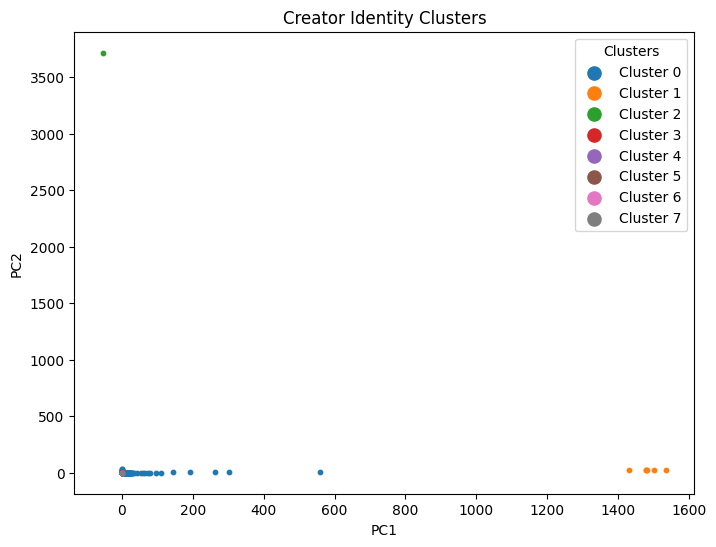

In [325]:
plt.figure(figsize=(8,6))

# use tab10 colormap for distinct cluster colors
cmap = plt.get_cmap("tab10")

for cluster_id in sorted(creator_niche_prop['cluster'].unique()):
    subset = creator_niche_prop[creator_niche_prop['cluster'] == cluster_id]
    plt.scatter(
        subset['pc1'],
        subset['pc2'],
        s=10,
        color=cmap(cluster_id),
        label=f"Cluster {cluster_id}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Creator Identity Clusters")
plt.legend(title="Clusters", markerscale=3)
plt.show()


Points close together → similar identity patterns

Points far apart → very different identity patterns

Colors → K-Means cluster groups

Cluster 1&2 represents a small group of creators who rely heavily on a distinct and relatively rare set of niche identity hashtags. Their separation in PCA space indicates that this cluster uses identity markers that are not shared with other creator communities.

Step 17: compute cluster adjacency 

In [326]:
centroids = (
    creator_niche_prop.groupby("cluster")[["pc1", "pc2"]]
    .mean()
    .reset_index()
)

centroids

niche_tags,cluster,pc1,pc2
0,0,-0.033254,-0.014462
1,1,1484.094486,21.642252
2,2,-54.293672,3716.727562
3,3,-0.090613,2.368178
4,4,-0.081777,-0.025332
5,5,-0.118763,-0.037566
6,6,-0.078304,-0.023438
7,7,-0.094429,-0.007525


In [327]:
from scipy.spatial.distance import cdist

cluster_positions = centroids[["pc1", "pc2"]].values
distance_matrix = cdist(cluster_positions, cluster_positions, metric="euclidean")

distance_df = pd.DataFrame(
    distance_matrix,
    index=centroids["cluster"],
    columns=centroids["cluster"]
)

distance_df

cluster,0,1,2,3,4,5,6,7
cluster,,,,,,,,
0,0.000000,1484.285741,3717.138075,2.383331,0.049725,0.088575,0.045935,0.061567
1,1484.285741,0.000000,4002.535892,1484.310243,1484.334417,1484.371578,1484.330917,1484.346808
2,3717.138075,4002.535892,0.000000,3714.754850,3717.148235,3717.159929,3717.146392,3717.130245
3,2.383331,1484.310243,3714.754850,0.000000,2.393527,2.405910,2.391649,2.375706
4,0.049725,1484.334417,3717.148235,2.393527,0.000000,0.038957,0.003955,0.021844
5,0.088575,1484.371578,3717.159929,2.405910,0.038957,0.000000,0.042855,0.038661
6,0.045935,1484.330917,3717.146392,2.391649,0.003955,0.042855,0.000000,0.022655
7,0.061567,1484.346808,3717.130245,2.375706,0.021844,0.038661,0.022655,0.000000


In [328]:
#show the nearest neighbor for each cluster

adjacency = (
    distance_df
    .apply(lambda row: row.sort_values()[1:4].index.tolist(), axis=1)
    .to_frame(name="nearest_clusters")
)

adjacency

,nearest_clusters
cluster,
0,"[6, 4, 7]"
1,"[0, 3, 6]"
2,"[3, 7, 0]"
3,"[7, 0, 6]"
4,"[6, 7, 5]"
5,"[7, 4, 6]"
6,"[4, 7, 5]"
7,"[4, 6, 5]"


In [329]:
def distance_to_centroids(row):
    point = np.array([row['pc1'], row['pc2']])
    return np.linalg.norm(cluster_positions - point, axis=1)

creator_niche_prop['distances'] = creator_niche_prop.apply(distance_to_centroids, axis=1)

In [330]:
#ratio of the distance
creator_niche_prop['cluster_gap'] = creator_niche_prop['distances'].apply(
    lambda d: np.partition(d, 1)[1] - np.partition(d, 0)[0]
)

In [331]:
overlap_threshold = creator_niche_prop['cluster_gap'].quantile(0.10)
creator_niche_prop['is_overlap'] = creator_niche_prop['cluster_gap'] < overlap_threshold

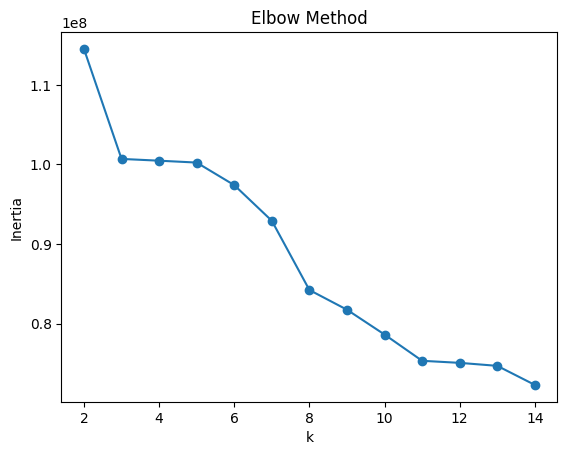

In [320]:
inertias = []
K = range(2, 15)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


Result:

About 2.25% of creators have overlapping identity characteristics

In [332]:
creator_niche_prop['is_overlap'].mean()

0.02252958040723081

In [333]:
creator_niche_prop['closest_clusters'] = creator_niche_prop['distances'].apply(
    lambda d: np.argsort(d)[:3].tolist()
)
creator_niche_prop[creator_niche_prop['is_overlap']].head()

niche_tags,00td,111,11minutesapart,2000sthrowbacks,222,30weeks,32weeks,33weeks,3rdnorth,3yearsold,...,🔥legit🔥empire🔥modz✅,🔥🌹imperial🦋hermosa⚜️,🤍💎💫sheikhsdiamonds💫💎🤍,cluster,pc1,pc2,distances,cluster_gap,is_overlap,closest_clusters
creator_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,-0.054314,-0.016497,"[0.021158033811855048, 1484.3068285272589, 371...",0.003816,True,"[0, 6, 4]"
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,-0.054314,-0.016497,"[0.021158033811857237, 1484.3068285272589, 371...",0.003816,True,"[0, 6, 4]"
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,-0.054314,-0.016497,"[0.02115803381185722, 1484.3068285272589, 3717...",0.003816,True,"[0, 6, 4]"
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,-0.054314,-0.016497,"[0.021158033811857428, 1484.3068285272589, 371...",0.003816,True,"[0, 6, 4]"
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,-0.054406,-0.016523,"[0.02125184002824514, 1484.3069206531768, 3717...",0.003627,True,"[0, 6, 4]"


Step 17: co-occurrence

In [335]:
import scipy.sparse as sp
# Build creator–identity binary matrix
creator_matrix = (
    post_niche_matrix
    .groupby("creator_id", sort=False)
    .any()
    .astype(int)
)

# Convert to sparse
creator_sparse = sp.csr_matrix(creator_matrix.values)

# Fast sparse dot product
co_occurrence_sparse = creator_sparse.T.dot(creator_sparse)

Identify identity pairs that often appear together

In [336]:
coo = sp.triu(co_occurrence_sparse, k=1).tocoo()

co_pairs_df = pd.DataFrame({
    "identity_1": creator_matrix.columns[coo.row],
    "identity_2": creator_matrix.columns[coo.col],
    "count": coo.data
})

# Sort by count descending
co_pairs_df = co_pairs_df.sort_values("count", ascending=False)

In [337]:
threshold = 20  #pairs that appear in at least 20 creators
common_pairs = co_pairs_df[co_pairs_df['count'] >= threshold]

In [338]:
common_pairs.head()

,identity_1,identity_2,count
6394,acotar,sarahjmaas,54
5368,reader,readersoftiktok,44
1425,acotar,fourthwing,37
6136,bookrecs,romancebooks,35
6734,acotar,sjm,34


In [339]:
co_occ_counts = co_occurrence_sparse.sum(axis=0).A1  # sum of each column
bridge_df = pd.DataFrame({
    "identity": creator_matrix.columns,
    "total_co_occurrences": co_occ_counts
}).sort_values("total_co_occurrences", ascending=False)

Identities with high total co-occurrence connect to many others

In [340]:
bridge_df.head()

,identity,total_co_occurrences
129,ex,974
53,bookrecs,861
21,acotar,849
308,psychic,845
310,psychicreading,826


In [341]:
import networkx as nx
G = nx.Graph()
coo = sp.triu(co_occurrence_sparse, k=1).tocoo()
for i, j, w in zip(coo.row, coo.col, coo.data):
    G.add_edge(creator_matrix.columns[i], creator_matrix.columns[j], weight=w)

# Detect communities (clusters)
partition = community_louvain.best_partition(G, weight='weight')
# partition is a dict: identity -> cluster_id

Step 18: compute within-creator consistency

In [357]:
# identity columns = the ones present in the partition dict
identity_cols = list(partition.keys())

def assign_post_cluster(row):
    # find the identity columns that are active in this row
    active_identities = [col for col in identity_cols if row.get(col, 0) == 1]

    # map those identities to their clusters
    clusters = [partition[identity] for identity in active_identities]

    if clusters:
        # return the most frequent cluster
        return max(set(clusters), key=clusters.count)
    else:
        return None

post_niche_matrix['dominant_cluster'] = post_niche_matrix.apply(assign_post_cluster, axis=1)


In [358]:
creator_stats = []

for creator_id, group in post_niche_matrix.groupby('creator_id'):
    clusters = group['dominant_cluster'].dropna().values
    if len(clusters) == 0:
        continue

    #dominant cluster
    from collections import Counter
    counts = Counter(clusters)
    dominant_cluster = counts.most_common(1)[0][0]
    pct_dominant = counts[dominant_cluster] / len(clusters)

    #switching rate
    switches = sum(clusters[i] != clusters[i-1] for i in range(1, len(clusters)))
    switch_rate = switches / (len(clusters)-1) if len(clusters) > 1 else 0

    creator_stats.append({
        "creator_id": creator_id,
        "dominant_cluster": dominant_cluster,
        "pct_dominant_cluster": pct_dominant,
        "switch_rate": switch_rate,
        "num_posts": len(clusters)
    })

creator_stats_df = pd.DataFrame(creator_stats)

In [359]:
creator_stats_df['strategy'] = creator_stats_df.apply(
    lambda x: 'persistent' if x['pct_dominant_cluster'] > 0.7 and x['switch_rate'] < 0.3 else 'fluid', axis=1
)

In [360]:
cluster_stats = creator_stats_df.groupby('dominant_cluster').agg(
    avg_pct_dominant=('pct_dominant_cluster', 'mean'),
    avg_switch_rate=('switch_rate', 'mean'),
    num_creators=('creator_id', 'count')
).reset_index()

Results:

In [361]:
creator_stats_df.head()

,creator_id,dominant_cluster,pct_dominant_cluster,switch_rate,num_posts,strategy
0,9,1.0,1.0,0.0,2,persistent
1,29,1.0,1.0,0.0,1,persistent
2,64,7.0,1.0,0.0,1,persistent
3,95,7.0,1.0,0.0,1,persistent
4,187,5.0,1.0,0.0,1,persistent


In [362]:
cluster_stats

,dominant_cluster,avg_pct_dominant,avg_switch_rate,num_creators
0,0.0,0.961229,0.069381,1000
1,1.0,0.973040,0.048805,4162
2,2.0,1.000000,0.000000,27
3,3.0,0.961598,0.064823,926
4,4.0,1.000000,0.000000,1
5,5.0,0.952758,0.083185,1122
6,6.0,0.964775,0.062720,478
7,7.0,0.970185,0.052037,2079
8,8.0,1.000000,0.000000,3


<Figure size 1000x500 with 0 Axes>

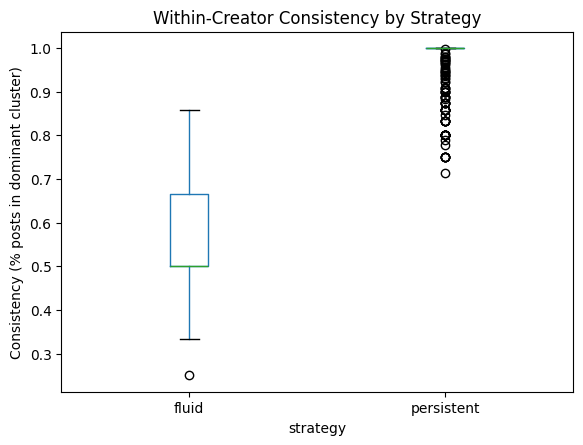

In [363]:
plt.figure(figsize=(10,5))
creator_stats_df.boxplot(column='pct_dominant_cluster', by='strategy', grid=False)
plt.ylabel('Consistency (% posts in dominant cluster)')
plt.title('Within-Creator Consistency by Strategy')
plt.suptitle('')
plt.show()

<Figure size 1000x500 with 0 Axes>

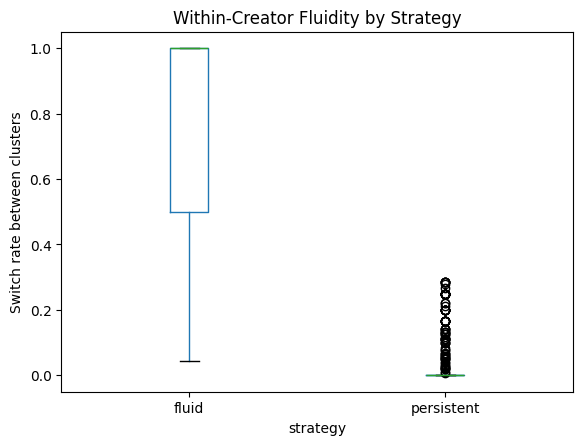

In [364]:
plt.figure(figsize=(10,5))
creator_stats_df.boxplot(column='switch_rate', by='strategy', grid=False)
plt.ylabel('Switch rate between clusters')
plt.title('Within-Creator Fluidity by Strategy')
plt.suptitle('')
plt.show()

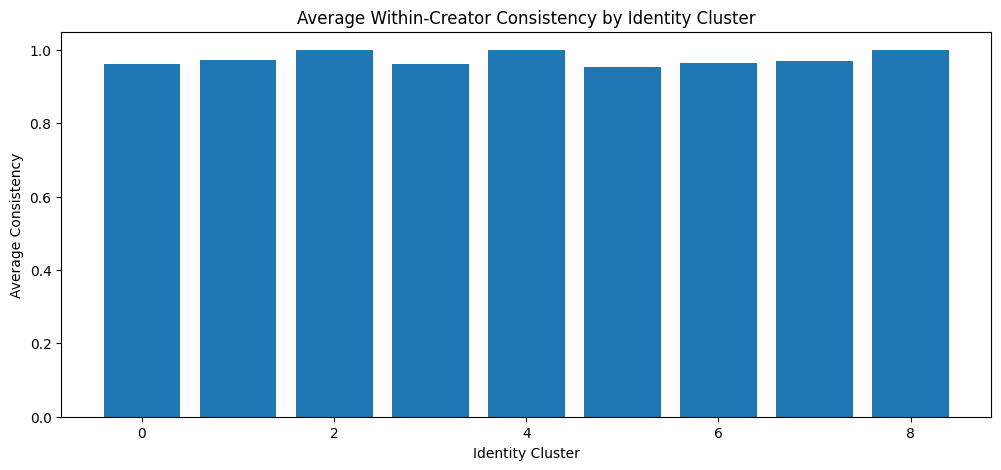

In [365]:
plt.figure(figsize=(12,5))
plt.bar(cluster_stats['dominant_cluster'], cluster_stats['avg_pct_dominant'])
plt.xlabel('Identity Cluster')
plt.ylabel('Average Consistency')
plt.title('Average Within-Creator Consistency by Identity Cluster')
plt.show()

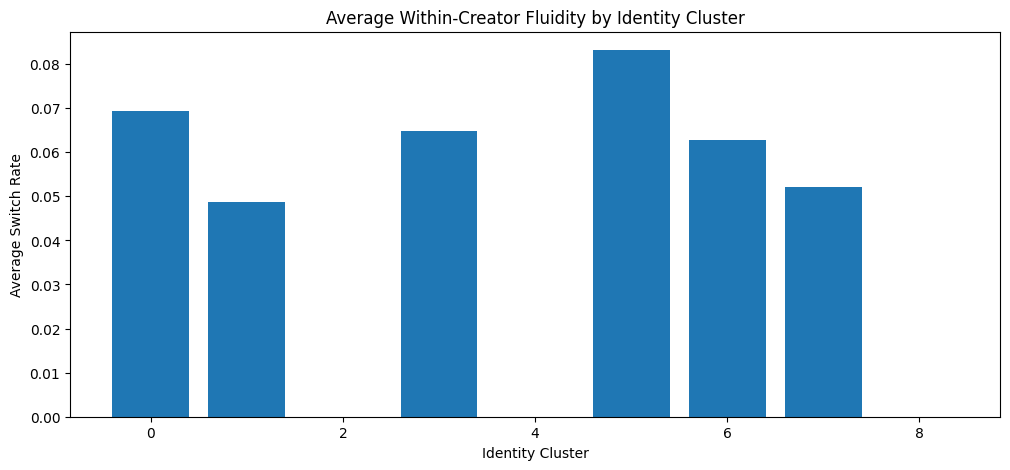

In [366]:
plt.figure(figsize=(12,5))
plt.bar(cluster_stats['dominant_cluster'], cluster_stats['avg_switch_rate'])
plt.xlabel('Identity Cluster')
plt.ylabel('Average Switch Rate')
plt.title('Average Within-Creator Fluidity by Identity Cluster')
plt.show()

FINAL RESULTS: 

In [ ]:
# Create a dict to hold the dominant identity per cluster
top_identities_per_cluster = {}

# Loop over all clusters
for cluster_id in set(partition.values()):
    # Find identities in this cluster
    identities_in_cluster = [idn for idn, cid in partition.items() if cid == cluster_id]

    # Subset the matrix to these identity columns
    submatrix = post_niche_matrix[identities_in_cluster]

    # Sum over posts to see how often each identity appears
    identity_counts = submatrix.sum()

    # Get the top 3 identities
    top_3 = identity_counts.sort_values(ascending=False).head(3)

    top_identities_per_cluster[cluster_id] = list(top_3.items())

top_identities_per_cluster

{0: [('ex', 453), ('divorcedparents', 434), ('psychic', 425)],
 1: [('goodluck', 482), ('twinsofinstagram', 472), ('redneck', 472)],
 2: [('girlsthatwearjewelry', 250),
  ('stainlesssteeljewelry', 246),
  ('goldplatedjewelry', 245)],
 3: [('latinainfluencer', 357), ('newgoals', 325), ('france', 279)],
 4: [('gratefulthankfulblessed🙏🏻', 355), ('mamaof3💙💜💙', 355), ('wifey💍', 355)],
 5: [('lovespelling', 492), ('gf', 448), ('accurate', 423)],
 6: [('muchlove', 489), ('hiphop', 456), ('stayclassy', 398)],
 7: [('bookrecs', 468), ('fantasy', 437), ('booktokfyp', 435)],
 8: [('mamabearof4', 459), ('mammabearof4', 216), ('hallowsmonth', 102)]}

In [354]:
print("=== Top 20 Co-occurring Identity Pairs ===")
print(co_pairs_df.head(20), "\n")

=== Top 20 Co-occurring Identity Pairs ===
           identity_1                identity_2  count
6394           acotar                sarahjmaas     54
5368           reader           readersoftiktok     44
1425           acotar                fourthwing     37
6136         bookrecs              romancebooks     35
6734           acotar                       sjm     34
340          bookrecs                booktokfyp     34
6116  kindleunlimited              romancebooks     33
1159           acotar                   fantasy     32
9210           acotar             throneofglass     31
1259         fiberart               fiberartist     31
9195       sarahjmaas             throneofglass     31
5374       booktokfyp           readersoftiktok     30
215          bookrecs                bookreview     28
2432         bookrecs           kindleunlimited     27
5363         bookrecs           readersoftiktok     27
2749     longdistance  longdistancerelationship     27
6130       bookreview 

In [355]:
print("=== Top 20 Bridge Identities ===")
print(bridge_df.head(20), "\n")

=== Top 20 Bridge Identities ===
                 identity  total_co_occurrences
129                    ex                   974
53               bookrecs                   861
21                 acotar                   849
308               psychic                   845
310        psychicreading                   826
359    spiritualawakening                   804
137               fantasy                   802
210       kindleunlimited                   800
328  relationshipproblems                   796
57              bookshelf                   791
10                    444                   783
133           exbackspell                   759
234       lovespellmaster                   757
4                     222                   756
334          romancebooks                   753
360      spiritualjourney                   751
70            brokenheart                   748
186       husbandwifelove                   736
62             booktokfyp                   728
54     

=== Identity Cluster Stability ===
                  avg_pct_dominant  avg_switch_rate  num_creators
dominant_cluster                                                 
0.0                       0.961229         0.069381          1000
1.0                       0.973040         0.048805          4162
2.0                       1.000000         0.000000            27
3.0                       0.961598         0.064823           926
4.0                       1.000000         0.000000             1
5.0                       0.952758         0.083185          1122
6.0                       0.964775         0.062720           478
7.0                       0.970185         0.052037          2079
8.0                       1.000000         0.000000             3 



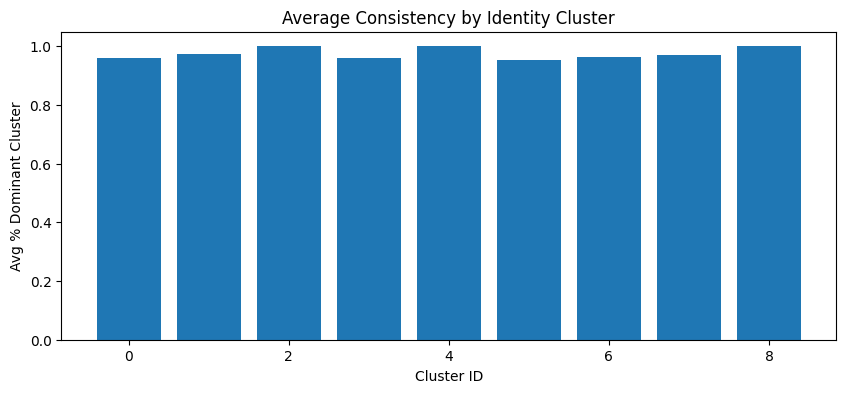

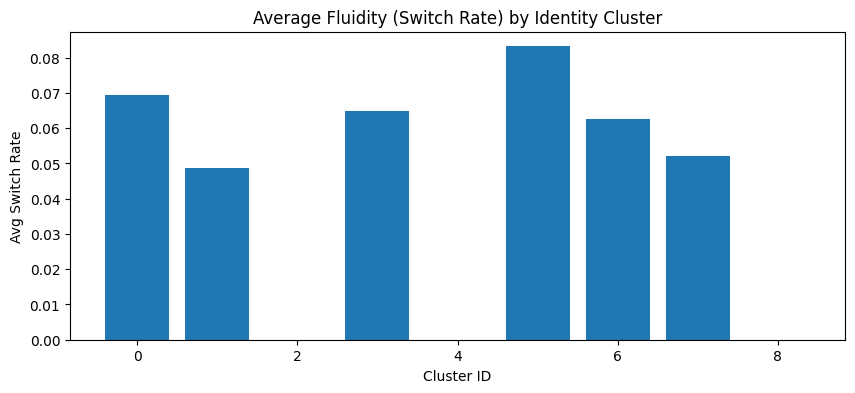

In [370]:


# ============================================================
# 7. CLUSTER-LEVEL STABILITY (identity differences)
# ============================================================

cluster_stats = creator_stats_df.groupby("dominant_cluster").agg(
    avg_pct_dominant=("pct_dominant_cluster", "mean"),
    avg_switch_rate=("switch_rate", "mean"),
    num_creators=("creator_id", "count")
).sort_index()

print("=== Identity Cluster Stability ===")
print(cluster_stats, "\n")

plt.figure(figsize=(10,4))
plt.bar(cluster_stats.index, cluster_stats.avg_pct_dominant)
plt.title("Average Consistency by Identity Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Avg % Dominant Cluster")
plt.show()

plt.figure(figsize=(10,4))
plt.bar(cluster_stats.index, cluster_stats.avg_switch_rate)
plt.title("Average Fluidity (Switch Rate) by Identity Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Avg Switch Rate")
plt.show()
